In [1]:
import pandas as pd

pd.set_option("display.max_columns", None)  # Toont alle kolommen
pd.set_option("display.width", 100)  # Voorkomt afkapping van kolommen
pd.set_option("display.max_rows", 1400)  # Beperkt aantal rijen om overzichtelijk te blijven

In [2]:
df_Full_dataset = pd.read_csv('TEG_Data&Weather_2Years_WithNAN.csv')

In [ ]:
import pandas as pd

df = df_Full_dataset

df['Timestamp'] = pd.to_datetime(df['Timestamp'])

df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Month'] = df['Timestamp'].dt.month

In [ ]:
import numpy as np
import pandas as pd

df = df_Full_dataset.copy()
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
df = df.set_index("Timestamp").sort_index()

df["Energy_lag_1"] = df["Energy (J)"].shift(1)
df["Energy_lag_2"] = df["Energy (J)"].shift(2)
df["Moving_average_energy_3"] = df["Energy (J)"].shift(1).rolling(window=3).mean()

df["Direct_radiation_lag_1"] = df["direct_rad:W"].shift(1)
df["Direct_radiation_lag_2"] = df["direct_rad:W"].shift(2)
df["Moving_average_direct_radiation_3"] = df["direct_rad:W"].shift(1).rolling(window=3).mean()

df["Ambient_Temperature_lag_1"] = df["Ambient_Temperature"].shift(1)
df["Ambient_Temperature_lag_2"] = df["Ambient_Temperature"].shift(2)
df["Moving_average_Ambient_Temperature_3"] = df["Ambient_Temperature"].shift(1).rolling(window=3).mean()

df["Ground_50cm_Temperature_lag_1"] = df["Ground_50cm_Temperature"].shift(1)
df["Ground_50cm_Temperature_lag_2"] = df["Ground_50cm_Temperature"].shift(2)
df["Moving_average_Ground_50cm_Temperature_3"] = df["Ground_50cm_Temperature"].shift(1).rolling(window=3).mean()

df["Hour_direct_interaction"] = df["Hour"] * df["direct_rad:W"]

# Targets
df["Energy_sum_target_30minutes"] = df["Energy (J)"].shift(-5).rolling(window=6, min_periods=6).sum()
df["Energy_sum_target_1hour"] = df["Energy (J)"].shift(-11).rolling(window=12, min_periods=12).sum()
df["Energy_sum_target_6hours"] = df["Energy (J)"].shift(-66).rolling(window=72, min_periods=72).sum()
df["Energy_sum_target_12hours"] = df["Energy (J)"].shift(-132).rolling(window=144, min_periods=144).sum()
df["Energy_sum_target_24hours"] = df["Energy (J)"].shift(-264).rolling(window=288, min_periods=288).sum()

YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()



In [ ]:
import numpy as np, pandas as pd, math, warnings, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")


# 1.  Dataframe & tijdindex
if not isinstance(df.index, pd.DatetimeIndex):
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    df = df.set_index("Timestamp").sort_index()

# 2.  Feature-set & target
features = [
    "direct_rad:W",
    "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature",
    "Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature",
    "Moving_average_energy_3",
    "Hour",
    "Month",

    "precip_5min:mm",
    "dew_point_2m:C",
    "relative_humidity_2m:p",
    "visibility:m",
    "wind_dir_10m:d",
    "wind_speed_10m:ms",
    "sfc_pressure:Pa"
]
target = "Energy_sum_target_1hour"


# 3.  Jaarblokken en 80/20-split
split_ix = int(len(YEAR1)*0.80)
train_df = YEAR1.iloc[:split_ix]
val_df   = YEAR1.iloc[split_ix:]


# 4.  Sliding-window sequenties
LOOKBACK = 12

scaler = MinMaxScaler()

def to_sequences(frame, fit=False):
    X_raw = frame[features].values
    y_raw = frame[target].values.reshape(-1, 1)

    if fit:
        scaler.fit(X_raw)
    X_scaled = scaler.transform(X_raw)

    X_seq, y_seq = [], []
    for i in range(LOOKBACK, len(frame)):
        X_seq.append(X_scaled[i-LOOKBACK:i])
        y_seq.append(y_raw[i])
    return np.array(X_seq), np.array(y_seq).squeeze()

X_tr, y_tr = to_sequences(train_df, fit=True)
X_val, y_val = to_sequences(val_df)

# 5.  ✏️ Hyperparameters
n_lstm_layers = 1
lstm_units    = 64
dropout_rate  = 0.0
dense_units   = 32
lr            = 0.0014554296980119005
batch_size    = 128
max_epochs    = 50

# 6.  LSTM-model met variabele structuur
tf.keras.backend.clear_session()
model = models.Sequential()
model.add(layers.Input(shape=(LOOKBACK, len(features))))

for i in range(n_lstm_layers):
    return_seq = (i < n_lstm_layers - 1)
    model.add(layers.LSTM(lstm_units, return_sequences=return_seq))
    if dropout_rate > 0:
        model.add(layers.Dropout(dropout_rate))

model.add(layers.Dense(dense_units, activation="relu"))
model.add(layers.Dense(1))

opt = optimizers.Adam(learning_rate=lr)
model.compile(optimizer=opt, loss="mse", metrics=["mae"])

early = callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=1)

history = model.fit(
    X_tr, y_tr,
    validation_data=(X_val, y_val),
    epochs=max_epochs,
    batch_size=batch_size,
    callbacks=[early],
    verbose=2
)


# 7.  80/20-resultaten
def get_metrics(y_true, y_pred):
    return (mean_absolute_error(y_true, y_pred),
            math.sqrt(mean_squared_error(y_true, y_pred)),
            r2_score(y_true, y_pred))

mae_tr, rmse_tr, r2_tr = get_metrics(y_tr, model.predict(X_tr, verbose=0))
mae_v , rmse_v , r2_v  = get_metrics(y_val, model.predict(X_val, verbose=0))

print(f"\n80/20 split – TRAIN  MAE {mae_tr:.3f} | RMSE {rmse_tr:.3f} | R² {r2_tr:.3f}")
print(f"80/20 split – VAL    MAE {mae_v :.3f} | RMSE {rmse_v :.3f} | R² {r2_v :.3f}")


# 8.  Seizoens-evaluatie in jaar 2
season_blocks = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

print("\nSeizoens-scores (LSTM, jaar 2)")
mae_s, rmse_s, r2_s = [], [], []

buffer = YEAR1.iloc[-LOOKBACK:]

for name, d1, d2 in season_blocks:
    block = pd.concat([buffer, YEAR2.loc[d1:d2]])
    if len(block) <= LOOKBACK:
        print(f"{name:10s} – onvoldoende rijen")
        continue

    X_seq, y_seq = to_sequences(block, fit=False)
    X_seq, y_seq = X_seq[LOOKBACK:], y_seq[LOOKBACK:]

    y_pred = model.predict(X_seq, verbose=0).squeeze()
    mae, rmse, r2 = get_metrics(y_seq, y_pred)

    mae_s.append(mae); rmse_s.append(rmse); r2_s.append(r2)
    print(f"{name:10s}  MAE {mae:.3f} | RMSE {rmse:.3f} | R² {r2:.3f}")

if mae_s:
    print("\nGemiddeld over 4 seizoenen (LSTM)")
    print(f"  MAE  {np.mean(mae_s):.3f}")
    print(f"  RMSE {np.mean(rmse_s):.3f}")
    print(f"  R²   {np.mean(r2_s):.3f}")


Epoch 1/50
652/652 - 7s - loss: 1.2851 - mae: 0.4629 - val_loss: 1.5647 - val_mae: 0.5302 - 7s/epoch - 10ms/step
Epoch 2/50
652/652 - 5s - loss: 0.7052 - mae: 0.3013 - val_loss: 1.6193 - val_mae: 0.4915 - 5s/epoch - 7ms/step
Epoch 3/50
652/652 - 6s - loss: 0.5504 - mae: 0.2683 - val_loss: 1.4294 - val_mae: 0.4550 - 6s/epoch - 9ms/step
Epoch 4/50
652/652 - 6s - loss: 0.4957 - mae: 0.2555 - val_loss: 1.0428 - val_mae: 0.3882 - 6s/epoch - 9ms/step
Epoch 5/50
652/652 - 5s - loss: 0.4458 - mae: 0.2448 - val_loss: 1.0834 - val_mae: 0.3873 - 5s/epoch - 8ms/step
Epoch 6/50
652/652 - 5s - loss: 0.4118 - mae: 0.2346 - val_loss: 1.1055 - val_mae: 0.3925 - 5s/epoch - 8ms/step
Epoch 7/50
652/652 - 6s - loss: 0.3951 - mae: 0.2308 - val_loss: 0.8597 - val_mae: 0.3377 - 6s/epoch - 9ms/step
Epoch 8/50
652/652 - 6s - loss: 0.3782 - mae: 0.2255 - val_loss: 1.0653 - val_mae: 0.3716 - 6s/epoch - 9ms/step
Epoch 9/50
652/652 - 6s - loss: 0.3396 - mae: 0.2159 - val_loss: 0.7062 - val_mae: 0.3382 - 6s/epoch - 

In [ ]:
import optuna, tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

def build_and_train(trial):
    tf.keras.backend.clear_session()

    # hyper­parameters die Optuna zal zoeken 
    n_lstm_layers = trial.suggest_int("n_lstm_layers", 1, 2)
    lstm_units    = trial.suggest_categorical("lstm_units", [32, 64])
    dropout_rate  = trial.suggest_float("dropout", 0.0, 0.3, step=0.1)
    dense_units   = trial.suggest_categorical("dense_units", [16, 32, 64, 128])
    lr            = trial.suggest_loguniform("learning_rate", 1e-4, 1e-1)
    batch_size    = trial.suggest_categorical("batch_size", [128, 256])
    max_epochs    = trial.suggest_int("max_epochs", 10, 30)

    # model ­architectuur
    model = models.Sequential()
    model.add(layers.Input(shape=(LOOKBACK, len(features))))

    for i in range(n_lstm_layers):
        return_seq = i < n_lstm_layers - 1
        model.add(layers.LSTM(lstm_units, return_sequences=return_seq))
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(dense_units, activation="relu"))
    model.add(layers.Dense(1))

    opt = optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=opt, loss="mse", metrics=["mae"])

    early = callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=0)

    history = model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        epochs=max_epochs,
        batch_size=batch_size,
        callbacks=[early],
        verbose=0
    )
    # minimiseer validatie-MAE
    val_mae = min(history.history["val_mae"])
    return val_mae

# Optuna-studie
study = optuna.create_study(direction="minimize", study_name="LSTM_mae")
study.optimize(build_and_train, n_trials=20, timeout=None, show_progress_bar=True)

print("\nBeste trial:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")
print(f"Best val-MAE: {study.best_value:.4f}")


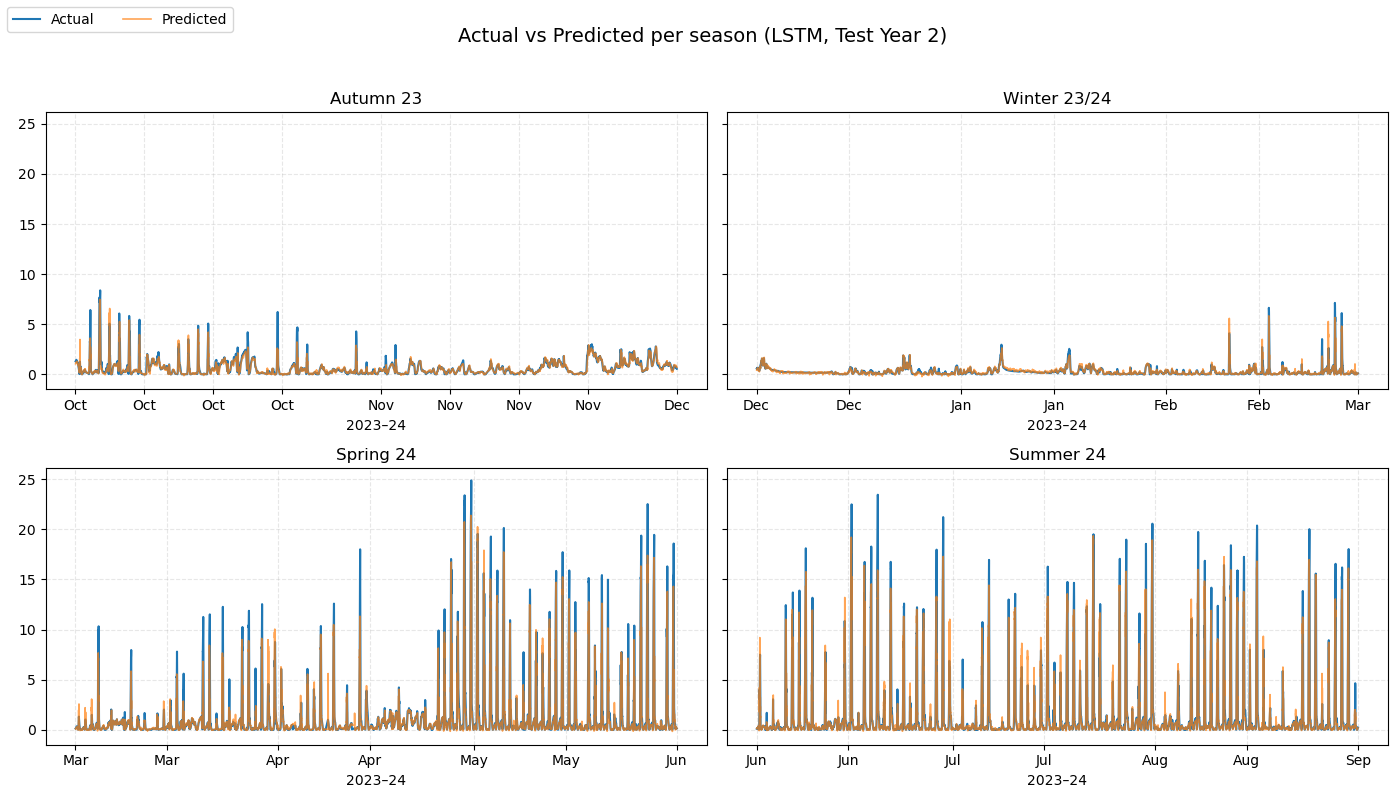

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

season_blocks_en = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 8), sharey=True)
axes = axes.ravel()

buffer = YEAR1.iloc[-LOOKBACK:]

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    block = pd.concat([buffer, YEAR2.loc[d1:d2]])
    if len(block) <= LOOKBACK:
        ax.set_visible(False)
        continue

    X_seq, y_seq = to_sequences(block, fit=False)
    X_seq, y_seq = X_seq[LOOKBACK:], y_seq[LOOKBACK:]

    y_pred = model.predict(X_seq, verbose=0).squeeze()

    # Bepaal de juiste datumindex voor de voorspellingen
    index = block.index[-len(y_seq):]

    ax.plot(index, y_seq, label="Actual", linewidth=1.5)
    ax.plot(index, y_pred, label="Predicted", linewidth=1.2, alpha=0.7)

    ax.set_title(title, fontsize=12)
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
    ax.set_xlabel("2023–24")
    ax.grid(True, linestyle="--", alpha=0.3)

# Legenda één keer bovenaan
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper left", ncol=2)

fig.suptitle("Actual vs Predicted per season (LSTM, Test Year 2)", y=0.97, fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [ ]:
def lstm_permutation_importance(model, X_seq, y_true, feature_names, repeats=1):
    baseline = model.evaluate(X_seq, y_true, verbose=0)[1]  # MAE

    n_features = X_seq.shape[2]
    impacts = []

    for i in range(n_features):
        scores = []
        for _ in range(repeats):
            X_permuted = X_seq.copy()
            
            for t in range(X_seq.shape[1]):
                np.random.shuffle(X_permuted[:, t, i])
            perm_mae = model.evaluate(X_permuted, y_true, verbose=0)[1]
            scores.append(perm_mae)

        delta_mae = np.mean(scores) - baseline
        impacts.append({
            "feature": feature_names[i],
            "delta_mae": delta_mae,
            "impact": abs(delta_mae)
        })

    df_imp = pd.DataFrame(impacts).sort_values("impact", ascending=True)
    return df_imp


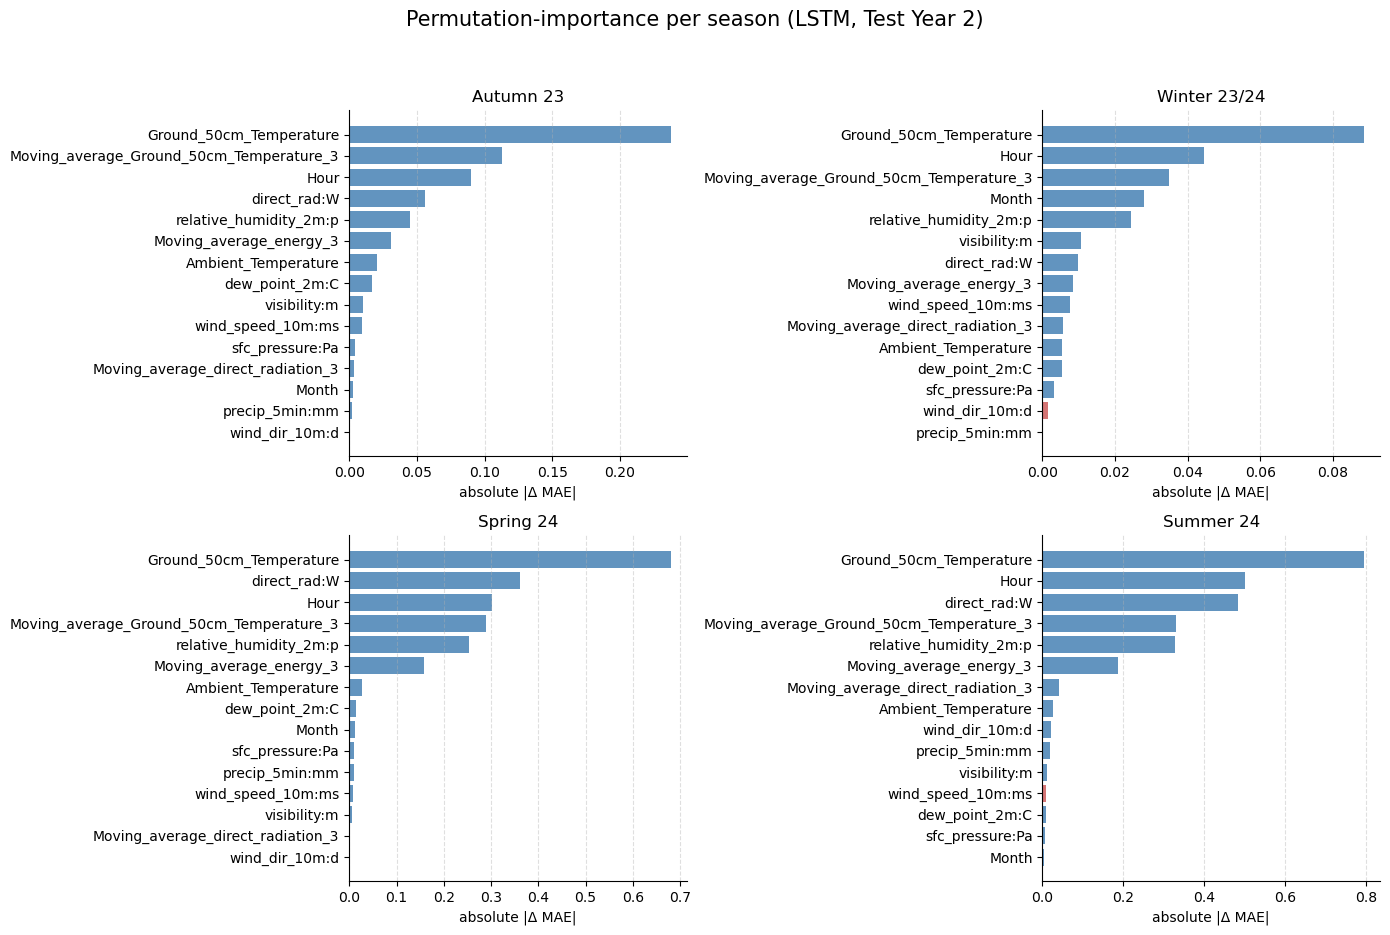

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

buffer = YEAR1.iloc[-LOOKBACK:]

for ax, (title, d1, d2) in zip(axes, season_blocks_en):
    blk = pd.concat([buffer, YEAR2.loc[d1:d2]])
    if len(blk) <= LOOKBACK:
        ax.axis("off")
        ax.set_title(f"{title}\n(no data)")
        continue

    X_blk, y_blk = to_sequences(blk, fit=False)
    X_blk, y_blk = X_blk[LOOKBACK:], y_blk[LOOKBACK:]

    imp_df = lstm_permutation_importance(model, X_blk, y_blk, features, repeats=1)

    colors = ["indianred" if x < 0 else "steelblue" for x in imp_df["delta_mae"]]

    ax.barh(imp_df["feature"], imp_df["impact"], color=colors, alpha=0.85)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("absolute |Δ MAE|")

    for spine in ["top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.grid(axis="x", linestyle="--", alpha=0.4)

plt.suptitle("Permutation-importance per season (LSTM, Test Year 2)", fontsize=15, y=0.93)
plt.tight_layout(rect=[0, 0, 1, 0.90])
plt.show()


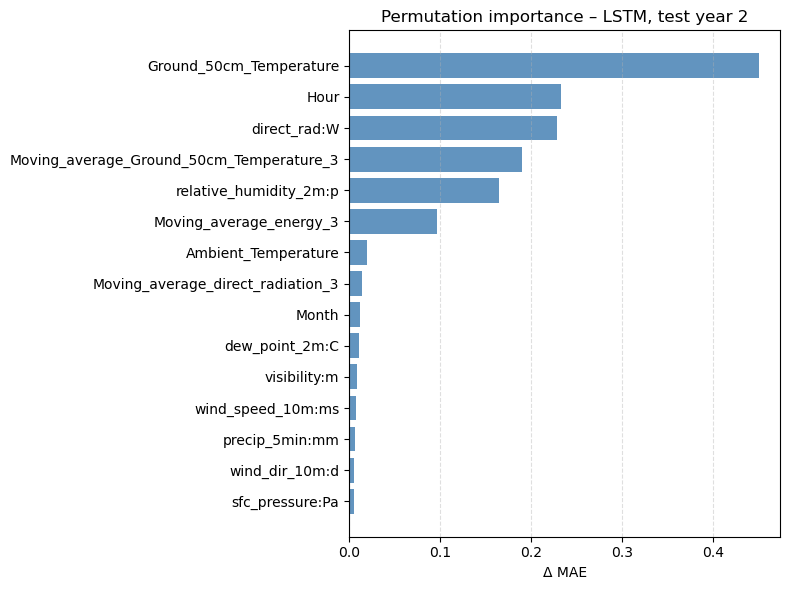

In [ ]:
impact_dict = {f: [] for f in features}
buffer = YEAR1.iloc[-LOOKBACK:]

for _, d1, d2 in season_blocks_en:
    blk = pd.concat([buffer, YEAR2.loc[d1:d2]])
    if len(blk) <= LOOKBACK:
        continue

    X_blk, y_blk = to_sequences(blk, fit=False)
    X_blk, y_blk = X_blk[LOOKBACK:], y_blk[LOOKBACK:]

    imp_df = lstm_permutation_importance(model, X_blk, y_blk, features, repeats=1)

    for _, row in imp_df.iterrows():
        impact_dict[row["feature"]].append(row["impact"])

avg_imp = {
    f: np.mean(vals) for f, vals in impact_dict.items() if vals  
}
imp_series = pd.Series(avg_imp).sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 6))
plt.barh(imp_series.index, imp_series.values, color="steelblue", alpha=0.85)
plt.xlabel("Δ MAE")
plt.title("Permutation importance – LSTM, test year 2")
plt.grid(axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np, pandas as pd, math, tensorflow as tf, warnings
from tensorflow.keras import layers, models, callbacks, optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
warnings.filterwarnings("ignore")

# Parameters 
LOOKBACK = 12        # 12×5 min = 1 uur
BASE_PARAMS = {
    "n_lstm_layers": 1,
    "lstm_units":    64,
    "dropout":       0.0,
    "dense_units":   32,
    "learning_rate": 0.0014554296980119005,
    "batch_size":    128,
    "epochs":        25,
}
horizons = {
    "30minutes": (5, 6),
    "1hour":     (11, 12),
    "6hours":    (66, 72),
    "12hours":   (132, 144),
    "24hours":   (264, 288)
}
features = [
    "direct_rad:W", "Moving_average_direct_radiation_3",
    "Ground_50cm_Temperature", "Moving_average_Ground_50cm_Temperature_3",
    "Ambient_Temperature", "Moving_average_energy_3",
    "Hour", "Month"
]
season_blocks = [
    ("Autumn 23",  "2023-10-01", "2023-11-30"),
    ("Winter 23/24","2023-12-01", "2024-02-29"),
    ("Spring 24",  "2024-03-01", "2024-05-31"),
    ("Summer 24",  "2024-06-01", "2024-08-31"),
]

scaler = MinMaxScaler()

def to_seq(frame, target, fit=False):
    X_raw = frame[features].values
    y_raw = frame[target].values.reshape(-1, 1)
    if fit: scaler.fit(X_raw)
    X_sc = scaler.transform(X_raw)
    X_seq, y_seq = [], []
    for i in range(LOOKBACK, len(frame)):
        X_seq.append(X_sc[i-LOOKBACK:i])
        y_seq.append(y_raw[i])
    return np.array(X_seq), np.array(y_seq).squeeze()

def metrics(y_t, y_p):
    return (mean_absolute_error(y_t, y_p),
            math.sqrt(mean_squared_error(y_t, y_p)),
            r2_score(y_t, y_p))


YEAR1 = df.loc["2022-10-01":"2023-09-30"].dropna()
YEAR2 = df.loc["2023-10-01":"2024-08-31"].dropna()
buffer = YEAR1.iloc[-LOOKBACK:]          

# Horizons
summary_rows = []
for label, (shift_, win_) in horizons.items():
    target = f"Energy_sum_target_{label}"
    
    if target not in df.columns:
        df[target] = df["Energy (J)"].shift(-shift_).rolling(window=win_, min_periods=win_).sum()
    YEAR1_lbl = YEAR1.dropna(subset=[target])
    YEAR2_lbl = YEAR2.dropna(subset=[target])

    # 80/20-split
    split_ix = int(len(YEAR1_lbl)*0.8)
    tr_df, vl_df = YEAR1_lbl.iloc[:split_ix], YEAR1_lbl.iloc[split_ix:]

    X_tr, y_tr = to_seq(tr_df, target, fit=True)
    X_vl, y_vl = to_seq(vl_df, target)

    
    tf.keras.backend.clear_session()
    prm = BASE_PARAMS            
    mdl = models.Sequential()
    mdl.add(layers.Input(shape=(LOOKBACK, len(features))))
    for i in range(prm["n_lstm_layers"]):
        ret = i < prm["n_lstm_layers"]-1
        mdl.add(layers.LSTM(prm["lstm_units"], return_sequences=ret))
        if prm["dropout"]>0:
            mdl.add(layers.Dropout(prm["dropout"]))
    mdl.add(layers.Dense(prm["dense_units"], activation="relu"))
    mdl.add(layers.Dense(1))
    mdl.compile(optimizer=optimizers.Adam(prm["learning_rate"]),
                loss="mse", metrics=["mae"])

    early = callbacks.EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
    mdl.fit(X_tr, y_tr, validation_data=(X_vl, y_vl),
            epochs=prm["epochs"], batch_size=prm["batch_size"],
            callbacks=[early], verbose=0)

    # Metrics
    tr_mae, tr_rmse, tr_r2 = metrics(y_tr, mdl.predict(X_tr, verbose=0).squeeze())
    vl_mae, vl_rmse, vl_r2 = metrics(y_vl, mdl.predict(X_vl, verbose=0).squeeze())

    print(f"\n🌀 LSTM – Voorspelhorizon: {label}")
    print(f"  TRAIN   MAE {tr_mae:.3f} | RMSE {tr_rmse:.3f} | R² {tr_r2:.3f}")
    print(f"  VAL     MAE {vl_mae:.3f} | RMSE {vl_rmse:.3f} | R² {vl_r2:.3f}")
    print(f"  Seizoensscores (jaar 2)")

    # Seizoenen
    seas_mae, seas_rmse, seas_r2 = [], [], []
    for nm, d1, d2 in season_blocks:
        blk = pd.concat([buffer, YEAR2_lbl.loc[d1:d2]])
        if len(blk)<=LOOKBACK: continue
        X_b, y_b = to_seq(blk, target)
        X_b, y_b = X_b[LOOKBACK:], y_b[LOOKBACK:]
        y_p = mdl.predict(X_b, verbose=0).squeeze()
        m, r, r2v = metrics(y_b, y_p)
        seas_mae.append(m); seas_rmse.append(r); seas_r2.append(r2v)
        print(f"    {nm:10s}  MAE {m:.3f} | RMSE {r:.3f} | R² {r2v:.3f}")

    # Summary
    summary_rows.append({
        "Horizon": label,
        "Train MAE": tr_mae, "Train RMSE": tr_rmse, "Train R²": tr_r2,
        "Val MAE": vl_mae, "Val RMSE": vl_rmse, "Val R²": vl_r2,
        "Test MAE": np.mean(seas_mae), "Test RMSE": np.mean(seas_rmse),
        "Test R²":  np.mean(seas_r2)
    })


df_summary = pd.DataFrame(summary_rows)
print("\n📊 Samenvatting per horizon (LSTM):")
print(df_summary.round(3))



🌀 LSTM – Voorspelhorizon: 30minutes
  TRAIN   MAE 0.074 | RMSE 0.240 | R² 0.949
  VAL     MAE 0.122 | RMSE 0.348 | R² 0.951
  Seizoensscores (jaar 2)
    Autumn 23   MAE 0.058 | RMSE 0.150 | R² 0.874
    Winter 23/24  MAE 0.028 | RMSE 0.075 | R² 0.903
    Spring 24   MAE 0.198 | RMSE 0.690 | R² 0.801
    Summer 24   MAE 0.205 | RMSE 0.647 | R² 0.863

🌀 LSTM – Voorspelhorizon: 1hour
  TRAIN   MAE 0.207 | RMSE 0.523 | R² 0.937
  VAL     MAE 0.305 | RMSE 0.739 | R² 0.942
  Seizoensscores (jaar 2)
    Autumn 23   MAE 0.163 | RMSE 0.299 | R² 0.866
    Winter 23/24  MAE 0.086 | RMSE 0.178 | R² 0.858
    Spring 24   MAE 0.393 | RMSE 1.168 | R² 0.850
    Summer 24   MAE 0.435 | RMSE 1.111 | R² 0.894

🌀 LSTM – Voorspelhorizon: 6hours
  TRAIN   MAE 1.739 | RMSE 3.699 | R² 0.839
  VAL     MAE 2.969 | RMSE 6.015 | R² 0.788
  Seizoensscores (jaar 2)
    Autumn 23   MAE 1.534 | RMSE 2.245 | R² 0.639
    Winter 23/24  MAE 0.790 | RMSE 1.426 | R² 0.593
    Spring 24   MAE 3.417 | RMSE 7.492 | R² 0.67